In [34]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
import tensorflow as tf

from utils import *

Setting up the devices for torch.

In [35]:
try:
  import torch_xla
  import torch_xla.core.xla_model as xm
  device = xm.xla_device()
  print("TPU is available. Using TPU")
except:
  if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
  else:
    device = torch.device("cpu")
    print("CUDA not available. Using CPU.")

CUDA is available. Using GPU.


In [36]:
torch.manual_seed(42)
np.random.seed(42)

In [37]:
(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.mnist.load_data()

**Loading the test and training data along with the labels**

In [38]:
train_data.shape
train_data = train_data.reshape(60000, -1).astype(np.float32) / 255.0
train_labels = train_labels.reshape(60000, -1).astype(np.float32).flatten()

train_data = torch.tensor(train_data)
train_labels = torch.tensor(train_labels).long()

test_data = test_data.reshape(10000, -1).astype(np.float32) / 255.0
test_labels = test_labels.reshape(10000, -1).astype(np.float32).flatten()

test_data = torch.tensor(test_data)
test_labels = torch.tensor(test_labels)

In [39]:
(f_train_data, f_train_labels) , (f_test_data, f_test_labels) = tf.keras.datasets.fashion_mnist.load_data()

In [40]:
f_train_data.shape
f_train_data = f_train_data.reshape(60000, -1).astype(np.float32) / 255.0
f_train_labels = f_train_labels.reshape(60000, -1).flatten()

f_train_data = torch.tensor(f_train_data)   
f_train_labels = torch.tensor(f_train_labels).long()

f_test_data = f_test_data.reshape(10000, -1).astype(np.float32) / 255.0
f_test_labels = f_test_labels.reshape(10000, -1).flatten()

f_test_data = torch.tensor(f_test_data)
f_test_labels = torch.tensor(f_test_labels)

In [41]:
#Passing one hot encoded labels to the model. NOT requiered since pytorch Crossentropy loss can directly take the labels as integers. Nonetheless, I have kept the code for reference.

# one_hot_train_labels = [[0 for i in range(10)] for j in range(60000)]
# for i in range(60000):
#     one_hot_train_labels[i][int(train_labels[i].item())] = 1

# one_hot_train_labels = torch.tensor(one_hot_train_labels)

# one_hot_test_labels = [[0 for i in range(10)] for j in range(10000)]
# for i in range(10000):
#     one_hot_test_labels[i][int(test_labels[i].item())] = 1

# one_hot_test_labels = torch.tensor(one_hot_test_labels)

In [42]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.layer_1 = nn.Linear(784,30)
        self.layer_2 = nn.Linear(30,20)
        self.layer_3 = nn.Linear(20,10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer_1(x))
        x = self.relu(self.layer_2(x))
        x = self.layer_3(x)
        return x

In [43]:
def train(net, lr, X, Y, epochs, verbose=True):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [44]:
net = Model().to(device)
train(net, 0.001, train_data.to(device), train_labels.to(device), 2000)

Epoch 0 loss: 2.311017
Epoch 100 loss: 0.495823
Epoch 200 loss: 0.303734
Epoch 300 loss: 0.234861
Epoch 400 loss: 0.181338
Epoch 500 loss: 0.146071
Epoch 600 loss: 0.122485
Epoch 700 loss: 0.104188
Epoch 800 loss: 0.088576
Epoch 900 loss: 0.076296
Epoch 1000 loss: 0.066414
Epoch 1100 loss: 0.058092
Epoch 1200 loss: 0.050853
Epoch 1300 loss: 0.044451
Epoch 1400 loss: 0.038806
Epoch 1500 loss: 0.033753
Epoch 1600 loss: 0.029195
Epoch 1700 loss: 0.025112
Epoch 1800 loss: 0.021527
Epoch 1900 loss: 0.018421


0.015721594914793968

In [45]:
def predict(net, X):
    net.eval()
    with torch.no_grad():
        return net(X)

In [46]:
ans = predict(net, test_data.to(device))

finans = torch.argmax(ans, dim = 1).cpu().numpy()

print("The accuracy using the MLP is:", calculate_accuracy(finans, test_labels.numpy()))
print("\nThe per class precision and recall using the MLP is : \n")
MLP_metrics = calculate_metrics(finans, test_labels.numpy())
display(MLP_metrics)

The accuracy using the MLP is: 0.9591

The per class precision and recall using the MLP is : 



,class,precision,recall,f1 score
1,0,0.979592,0.978593,0.979092
2,1,0.986784,0.971379,0.979021
3,2,0.944767,0.95682,0.950756
4,3,0.952475,0.947783,0.950123
5,4,0.962322,0.959391,0.960854
6,5,0.936099,0.947787,0.941906
7,6,0.970772,0.959752,0.965231
8,7,0.950389,0.959725,0.955034
9,8,0.951745,0.949795,0.950769
10,9,0.951437,0.957129,0.954274



The confusion matrix using the MLP is : 



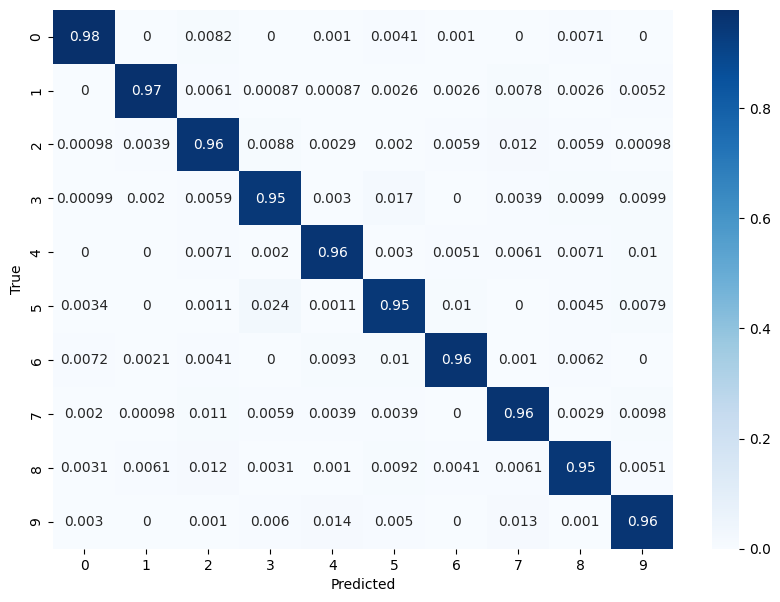

The top commonly confused classes are:
5  is interpreted to be  3
3  is interpreted to be  5
9  is interpreted to be  4
9  is interpreted to be  7
8  is interpreted to be  2
2  is interpreted to be  7
7  is interpreted to be  2
6  is interpreted to be  5
5  is interpreted to be  6
4  is interpreted to be  9


In [47]:
print("\nThe confusion matrix using the MLP is : \n")
CM_MLP = calculate_and_plot_confusion_matrix(finans, test_labels.numpy())
pick_outliers(CM_MLP)

In [48]:
random_forest = RandomForestClassifier(n_estimators=100, max_depth=64, min_samples_split=2, random_state=42)

random_forest.fit(train_data.cpu(), train_labels.cpu())
random_forest_pred = random_forest.predict(test_data)

In [49]:
print("The accuracy using the random forest is:", calculate_accuracy(random_forest_pred, test_labels.numpy()))
print("\nThe per class precision and recall using the Random Forest is : \n")
RF_metrics = calculate_metrics(random_forest_pred, test_labels.numpy())
display(RF_metrics)

The accuracy using the random forest is: 0.9704

The per class precision and recall using the Random Forest is : 



,class,precision,recall,f1 score
1,0,0.990816,0.968096,0.979324
2,1,0.992952,0.98773,0.990334
3,2,0.97093,0.961612,0.966249
4,3,0.962376,0.96333,0.962853
5,4,0.972505,0.97449,0.973496
6,5,0.964126,0.976163,0.970107
7,6,0.978079,0.976042,0.977059
8,7,0.962062,0.971513,0.966764
9,8,0.954825,0.961737,0.958269
10,9,0.952428,0.961962,0.957171



The confusion matrix using the Random Forest is : 



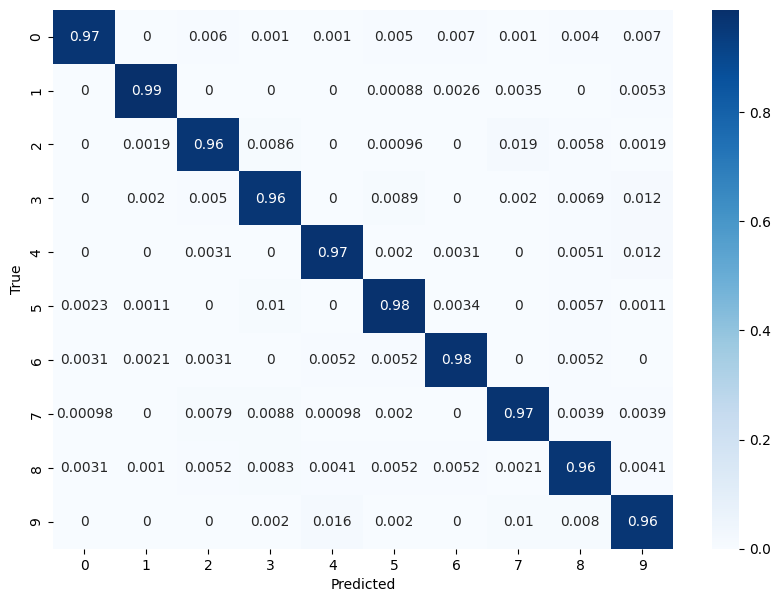

The top commonly confused classes are:
2  is interpreted to be  7
9  is interpreted to be  4
4  is interpreted to be  9
3  is interpreted to be  9
5  is interpreted to be  3
9  is interpreted to be  7
3  is interpreted to be  5
7  is interpreted to be  3
2  is interpreted to be  3
8  is interpreted to be  3


In [50]:
print("\nThe confusion matrix using the Random Forest is : \n")
CM_RF = calculate_and_plot_confusion_matrix(random_forest_pred, test_labels.numpy())
pick_outliers(CM_RF)

In [51]:
class LogisticModel(nn.Module):
    def __init__(self):
        super(LogisticModel, self).__init__()
        self.layer_1 = nn.Linear(784,10)

    def forward(self, x):
        x = self.layer_1(x)
        return x
    
def train_logistic(net, lr, X, Y, epochs, verbose=True):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [52]:
logistic_model = LogisticModel().to(device)
train_logistic(logistic_model, 0.0006, train_data.to(device), train_labels.to(device), 2000)

Epoch 0 loss: 2.312373
Epoch 100 loss: 0.864115
Epoch 200 loss: 0.594008
Epoch 300 loss: 0.488450
Epoch 400 loss: 0.431485
Epoch 500 loss: 0.395479
Epoch 600 loss: 0.370457
Epoch 700 loss: 0.351927
Epoch 800 loss: 0.337565
Epoch 900 loss: 0.326044
Epoch 1000 loss: 0.316551
Epoch 1100 loss: 0.308559
Epoch 1200 loss: 0.301713
Epoch 1300 loss: 0.295762
Epoch 1400 loss: 0.290528
Epoch 1500 loss: 0.285874
Epoch 1600 loss: 0.281702
Epoch 1700 loss: 0.277931
Epoch 1800 loss: 0.274501
Epoch 1900 loss: 0.271361


0.26850032806396484

In [53]:
logistic_pred = predict(logistic_model, test_data.to(device))

finans_logistic = torch.argmax(logistic_pred, dim = 1).cpu().numpy()

In [54]:
print("The accuracy using the logistic regression is:", calculate_accuracy(finans_logistic, test_labels.numpy()))
print("\nThe per class precision and recall using the logistic regression is : \n")
LR_metrics = calculate_metrics(finans_logistic, test_labels.numpy())
display(LR_metrics)

The accuracy using the logistic regression is: 0.9251

The per class precision and recall using the logistic regression is : 



,class,precision,recall,f1 score
1,0,0.97551,0.952191,0.96371
2,1,0.977974,0.966057,0.971979
3,2,0.886628,0.934627,0.909995
4,3,0.910891,0.903733,0.907298
5,4,0.936864,0.928355,0.93259
6,5,0.871076,0.908772,0.889525
7,6,0.958246,0.93578,0.94688
8,7,0.922179,0.931238,0.926686
9,8,0.894251,0.871872,0.882919
10,9,0.90783,0.910537,0.909181



The confusion matrix using the Logistic Regresssion is : 



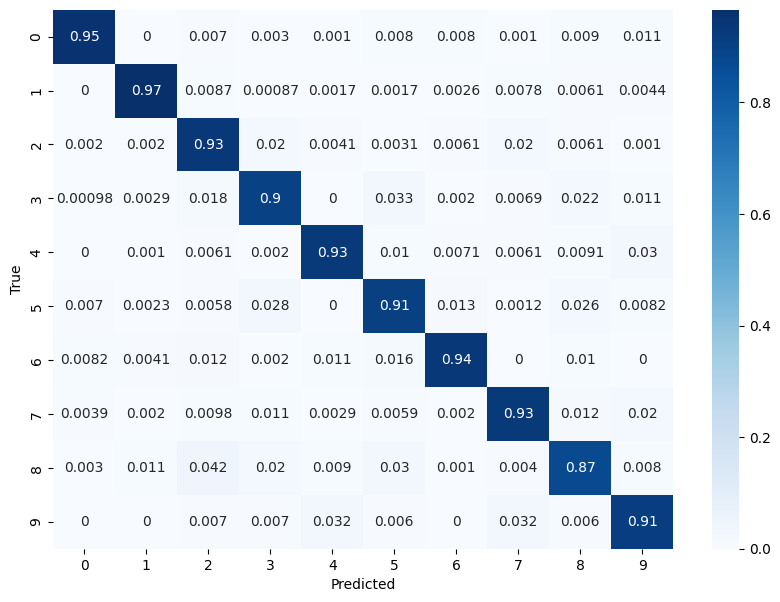

The top commonly confused classes are:
8  is interpreted to be  2
3  is interpreted to be  5
9  is interpreted to be  4
9  is interpreted to be  7
4  is interpreted to be  9
8  is interpreted to be  5
5  is interpreted to be  3
5  is interpreted to be  8
3  is interpreted to be  8
2  is interpreted to be  3


In [55]:
print("\nThe confusion matrix using the Logistic Regresssion is : \n")
CM_RF = calculate_and_plot_confusion_matrix(finans_logistic, test_labels.numpy())
pick_outliers(CM_RF)

We observe that the highest accuracy is given by the Random Forest Model followed by the MLP and the Vanilla Logistic Regression Model. By increasing the number of hidden layers in the MLP we can also get comparable accurcy to the Random Forest model. But to get a higher accuracy excedding 97 percent, it is better suited to use Convolutional Neural Networks or RNNs.

In [56]:
def get_outputs(model, data, layer):
    outputs = None
    def hook(module, input, output):
        nonlocal outputs
        outputs = (output.detach().cpu().numpy())
    
    handle = layer.register_forward_hook(hook)
    model.eval()
    with torch.no_grad():
        model(data.to(device))
        
    handle.remove()

    return outputs

trained_outputs = get_outputs(net, test_data, net.layer_2)

untrained_net = Model().to(device)

untrained_outputs = get_outputs(untrained_net, test_data, untrained_net.layer_2)

tsne = TSNE(n_components=2, random_state=42)
trained_tsne_results = tsne.fit_transform(trained_outputs)
untrained_tsne_results = tsne.fit_transform(untrained_outputs)


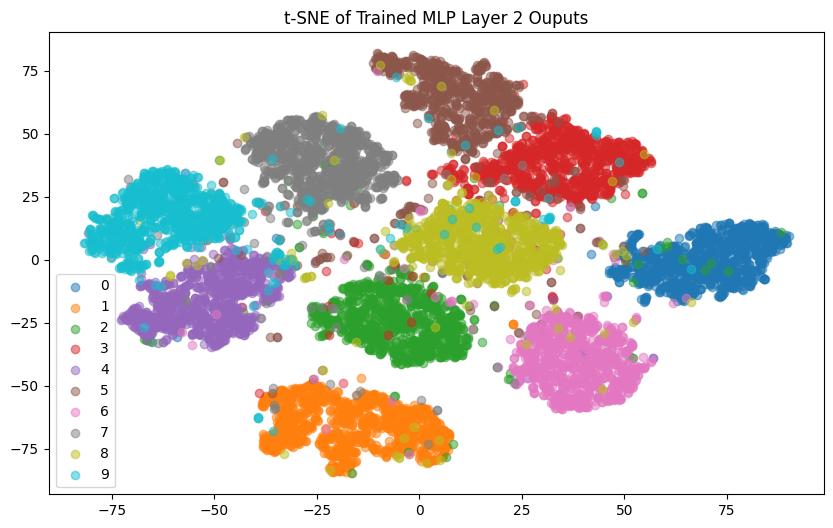

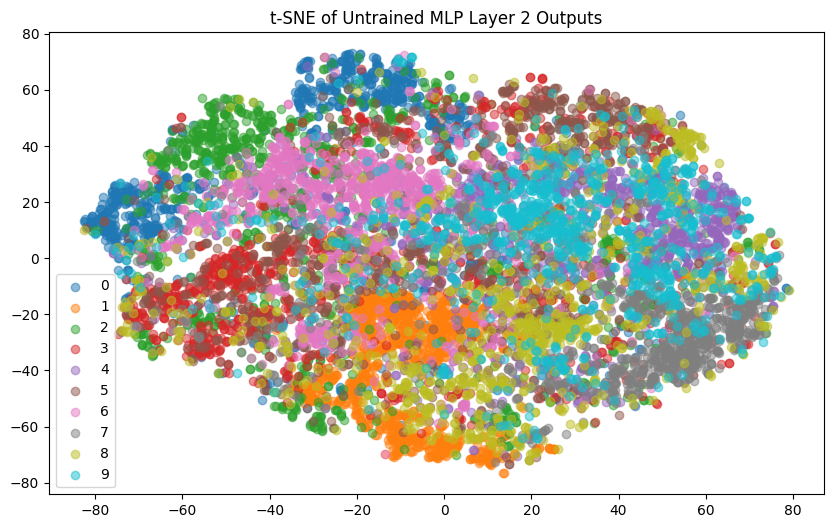

In [57]:
def plot_tsne(tsne_results, labels, title):
    plt.figure(figsize=(10, 6))
    for i in range(10):
        indices = (labels == i)
        plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1], label= i , alpha=0.5)
    plt.legend()
    plt.title(title)
    plt.show()

plot_tsne(trained_tsne_results, test_labels.numpy(), "t-SNE of Trained MLP Layer 2 Ouputs")

plot_tsne(untrained_tsne_results, test_labels.numpy(), "t-SNE of Untrained MLP Layer 2 Outputs")

From the plots of the outputs from the second layer for both the trained and untrained model, we can see that the MLP has learnt features in a manner that allows it seperate the 10 different classes of the dataset. In the untrained model's t-SNE plot, there no clear seperation between the different classes, whereas in the trained model, this seperation is very apparent with only a few outliers in the seperated regions.

An additional thing to notice is that, the t-SNE plot allows us to visualise the commonly confused classes as their regions are closer by, allowing for overlap.

Accuracy is :  0.0782


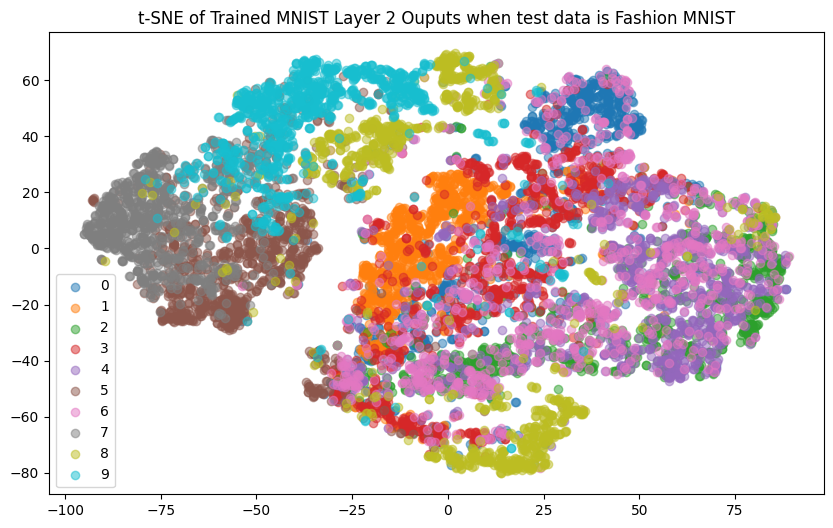

In [58]:
#using trained MLP to predict fashion mnist

predicted_fmnist = predict(net, f_test_data.to(device))
print("Accuracy is : ", calculate_accuracy(torch.argmax(predicted_fmnist, dim=1).cpu().numpy(), f_test_labels.numpy()))

f_trained_outputs = get_outputs(net, f_test_data, net.layer_2)
f_trained_outputs_tsne = tsne.fit_transform(f_trained_outputs)

plot_tsne(f_trained_outputs_tsne, f_test_labels.numpy(), "t-SNE of Trained MNIST Layer 2 Ouputs when test data is Fashion MNIST")

The accuracy is worse than randomnly guessing any of the ten classes.

From the t-SNE plot we can see that :

There is an attempt at seperating the different classes, but it is not very useful per se when we pass the fashion MNIST data into the MLP trained on the MNIST dataset. The model being a Vanilla MLP has not learnt any low level features like edges etc which could help in a downstream task, which could be learnt by CNNs, and it is only suitable for testing on the MNIST dataset and hence we do not get any good result here.